In [1]:
import pandas as pd
import numpy as np
import os
import os.path as op
import nibabel as nb

import glob

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from nilearn import plotting
from nilearn import image
import scipy.signal as sig
import seaborn as sns


In [2]:
def fsl_glm(input, design, output, demean=False, mask=None, out_z=None, des_norm=False):
    
    cmd = [
        f"{os.getenv('FSLDIR')}/bin/fsl_glm",
        '-i', func,
        '-d', design,
        '-o', output,
    ]
    
    if demean:
        cmd.append('--demean')
    if mask is not None:
        cmd.append('-m')
        cmd.append(mask)
    if out_z is not None:
        cmd.append(f'--out_z={out_z}')
    if des_norm:
        cmd.append('--des_norm')
        
    return ' '.join(cmd)


def fslsplit(input, output=None, axis='t'):
    
    cmd = [
        f"{os.getenv('FSLDIR')}/bin/fslsplit",
        input
    ]
    
    if output is not None:
        cmd.append(output)
    
    cmd.append('-'+axis)
    
    return ' '.join(cmd)

## Inputs 

In [4]:
func_names = glob.glob('/vol/dhcp-results/neofmri_3rd_release/workdir/sub*/ses*/hcp_surface/func_mesh-dhcp32kSym_space-extdhcp40wk_desc-cortexSmooth4mm.dtseries.nii')
print(len(func_names))

icadir = 'hcp_smooth4_dim25.gica'

809


# CIFTI to NIFTI

Convert the single-subject `cifti` functional dense time-series (`dtseries`) into a dummy `nifti` for use with `fsl_glm`.  

> **This only needs to be done once**

In [5]:
with open('cifti_to_nifti.txt', 'w') as fp:
    for f in func_names:
        fp.write(f"./convert_cifti_to_dummy.py {f} {f.replace('.dtseries.nii', '')}\n")
        
! head -n 2 cifti_to_nifti.txt
    
! echo fsl_sub -l logs -q long.q -R 12000 -t cifti_to_nifti.txt

./convert_cifti_to_dummy.py /vol/dhcp-results/neofmri_3rd_release/workdir/sub-CC00347XX18/ses-109600/hcp_surface/func_mesh-dhcp32kSym_space-extdhcp40wk_desc-cortexSmooth4mm.dtseries.nii /vol/dhcp-results/neofmri_3rd_release/workdir/sub-CC00347XX18/ses-109600/hcp_surface/func_mesh-dhcp32kSym_space-extdhcp40wk_desc-cortexSmooth4mm
./convert_cifti_to_dummy.py /vol/dhcp-results/neofmri_3rd_release/workdir/sub-CC00308XX11/ses-98900/hcp_surface/func_mesh-dhcp32kSym_space-extdhcp40wk_desc-cortexSmooth4mm.dtseries.nii /vol/dhcp-results/neofmri_3rd_release/workdir/sub-CC00308XX11/ses-98900/hcp_surface/func_mesh-dhcp32kSym_space-extdhcp40wk_desc-cortexSmooth4mm
fsl_sub -l logs -q long.q -R 12000 -t cifti_to_nifti.txt


In [6]:
! ./convert_cifti_to_dummy.py {icadir}/melodic_IC.dscalar.nii {icadir}/melodic_IC

# Dual Regression

In [7]:
# HCP surface mapping; 4mm surface smoothing; cortex only, 25 dim symmetric ICA
func_names = glob.glob('/vol/dhcp-results/neofmri_3rd_release/workdir/sub*/ses*/hcp_surface/func_mesh-dhcp32kSym_space-extdhcp40wk_desc-cortexSmooth4mm.dtseries.nii')
grp_map = f"{icadir}/melodic_IC.dummy.nii.gz"
grp_mask = f"{icadir}/melodic_IC_mask.dummy.nii.gz"
outdir = icadir.replace('.gica', '.dr')

In [8]:
subids = [f.split('/')[5].split('-')[1] for f in func_names]
sesids = [f.split('/')[6].split('-')[1] for f in func_names]

ts_names = [f"{outdir}/timecourse/sub-{subid}_ses-{sesid}.txt" for subid, sesid in zip(subids, sesids)]
map_names = [f"{outdir}/map/sub-{subid}_ses-{sesid}.dscalar.nii" for subid, sesid in zip(subids, sesids)]
z_names = [f"{outdir}/map/sub-{subid}_ses-{sesid}_Z.dscalar.nii" for subid, sesid in zip(subids, sesids)]
amp_names = [f"{outdir}/amplitude/sub-{subid}_ses-{sesid}.csv" for subid, sesid in zip(subids, sesids)]

# fsl_sub

queue = 'long.q'
logdir = f'{outdir}/logs'
other = '-R 24000'

**Stage A:** Regress group ICA grayordinates into single-subject func grayordinates to yield single-subect timeseries

In [9]:
if not op.exists(logdir):
    os.makedirs(logdir)
    
with open(f'{logdir}/drA.txt', 'w') as f:   

    for func, ts in zip(func_names, ts_names):

        if not op.exists(op.dirname(ts)):
            os.makedirs(op.dirname(ts))
            
        func = func.replace('.dtseries.nii', '.dummy.nii.gz')

        cmd = [
            fsl_glm(func, grp_map, ts, demean=True, mask=grp_mask),
        ]
    
        f.write(f"{'; '.join(cmd)}\n")

! head -n 1 {logdir}/drA.txt
! echo fsl_sub -q {queue} -l {logdir} -N drA {other} -t {logdir}/drA.txt

/vol/dhcp-results/fsl-6.0.3/bin/fsl_glm -i /vol/dhcp-results/neofmri_3rd_release/workdir/sub-CC00347XX18/ses-109600/hcp_surface/func_mesh-dhcp32kSym_space-extdhcp40wk_desc-cortexSmooth4mm.dummy.nii.gz -d hcp_smooth4_dim25.gica/melodic_IC.dummy.nii.gz -o hcp_smooth4_dim25.dr/timecourse/sub-CC00347XX18_ses-109600.txt --demean -m hcp_smooth4_dim25.gica/melodic_IC_mask.dummy.nii.gz
fsl_sub -q long.q -l hcp_smooth4_dim25.dr/logs -N drA -R 24000 -t hcp_smooth4_dim25.dr/logs/drA.txt


**Stage B:** Regress single-subject time-series into single-subject func 4D volume to yield single-subject maps

In [10]:
if not op.exists(logdir):
    os.makedirs(logdir)
    
with open(f'{logdir}/drB.txt', 'w') as f:   

    for func, ts, map0, z in zip(func_names, ts_names, map_names, z_names):

        if not op.exists(op.dirname(ts)):
            os.makedirs(op.dirname(ts))

        if not op.exists(op.dirname(map0)):
            os.makedirs(op.dirname(map0))
            
        map0 = map0.replace('.dscalar.nii', '.dummy.nii.gz')
        z = z.replace('.dscalar.nii', '.dummy.nii.gz')
        func = func.replace('.dtseries.nii', '.dummy.nii.gz')

        cmd = [
            fsl_glm(func, ts, map0, demean=True, mask=grp_mask, out_z=z, des_norm=True),
            fslsplit(map0, map0.replace('.dummy.nii.gz', '_ic'), axis='t'),
        ]
    
        f.write(f"{'; '.join(cmd)}\n")
        
! head -n 1 {logdir}/drB.txt
                
! echo fsl_sub -q {queue} -l {logdir} -N drB {other} -t {logdir}/drB.txt

/vol/dhcp-results/fsl-6.0.3/bin/fsl_glm -i /vol/dhcp-results/neofmri_3rd_release/workdir/sub-CC00347XX18/ses-109600/hcp_surface/func_mesh-dhcp32kSym_space-extdhcp40wk_desc-cortexSmooth4mm.dummy.nii.gz -d hcp_smooth4_dim25.dr/timecourse/sub-CC00347XX18_ses-109600.txt -o hcp_smooth4_dim25.dr/map/sub-CC00347XX18_ses-109600.dummy.nii.gz --demean -m hcp_smooth4_dim25.gica/melodic_IC_mask.dummy.nii.gz --out_z=hcp_smooth4_dim25.dr/map/sub-CC00347XX18_ses-109600_Z.dummy.nii.gz --des_norm; /vol/dhcp-results/fsl-6.0.3/bin/fslsplit hcp_smooth4_dim25.dr/map/sub-CC00347XX18_ses-109600.dummy.nii.gz hcp_smooth4_dim25.dr/map/sub-CC00347XX18_ses-109600_ic -t
fsl_sub -q long.q -l hcp_smooth4_dim25.dr/logs -N drB -R 24000 -t hcp_smooth4_dim25.dr/logs/drB.txt


**Stage C:** Merge maps

In [11]:
N = nb.load(grp_map).shape[-1]

with open(f'{logdir}/drC.txt', 'w') as f: 

    for i in np.arange(N):

        ic_names = [map0.replace('.dscalar.nii', f'_ic{i:04n}.nii.gz') for map0 in map_names]
        cmd =[
            f"{os.getenv('FSLDIR')}/bin/fslmerge -t {outdir}/map/ic{i:04n}_merged.dummy.nii.gz {' '.join(ic_names)}",
            f"rm {' '.join(ic_names)}",
            f"fslmaths {outdir}/map/ic{i:04n}_merged.dummy.nii.gz -Tmean {outdir}/map/ic{i:04n}_mean.dummy.nii.gz"
        ]
        f.write(f"{'; '.join(cmd)}\n")
        
# ! head -n 1 {logdir}/drC.txt
                
! echo fsl_sub -q {queue} -l {logdir} -N drC {other} -t {logdir}/drC.txt

fsl_sub -q long.q -l hcp_smooth4_dim25.dr/logs -N drC -R 24000 -t hcp_smooth4_dim25.dr/logs/drC.txt


**Stage D:** Group maps

In [12]:
mean_maps = [f'{outdir}/map/ic{i:04n}_mean.dummy.nii.gz' for i in np.arange(N)]
! echo fsl_sub -q {queue} -l {logdir} -N drD fslmerge -t {outdir}/map/group.dummy.nii.gz {' '.join(mean_maps)}

fsl_sub -q long.q -l hcp_smooth4_dim25.dr/logs -N drD fslmerge -t hcp_smooth4_dim25.dr/map/group.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0000_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0001_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0002_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0003_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0004_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0005_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0006_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0007_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0008_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0009_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0010_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0011_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0012_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0013_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0014_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0015_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0016_mean.dummy.nii.gz hcp_smooth4_dim25.dr/map/ic0017_mean.dum

**Convert dummy NIFTI to CIFTI**

In [13]:
dummy_niftis = glob.glob(f'{outdir}/map/*.dummy.nii.gz')

with open('nifti_to_cifti.txt', 'w') as fp:
    for f in dummy_niftis:
        outname = f.replace('.dummy.nii.gz', '.dscalar.nii')
        fp.write(f"./convert_dummy_to_cifti.py {f} {grp_mask} {grp_map.replace('.dummy.nii.gz', '.dscalar.nii')} {outname} dscalar\n")
    
! head -n 1 nifti_to_cifti.txt
    
! echo fsl_sub -l logs -q long.q -R 12000 -t nifti_to_cifti.txt

./convert_dummy_to_cifti.py hcp_smooth4_dim25.dr/map/sub-CC00501XX06_ses-146500_Z.dummy.nii.gz hcp_smooth4_dim25.gica/melodic_IC_mask.dummy.nii.gz hcp_smooth4_dim25.gica/melodic_IC.dscalar.nii hcp_smooth4_dim25.dr/map/sub-CC00501XX06_ses-146500_Z.dscalar.nii dscalar
fsl_sub -l logs -q long.q -R 12000 -t nifti_to_cifti.txt


# Amplitude

In [14]:
def nanmad(d, axis=None, keepdims=False):
    '''
    Calculate the median absolute deviation (MAD) accounting for NaNs.
    (see: https://en.wikipedia.org/wiki/Median_absolute_deviation)
    '''
    median = np.nanmedian(d, axis=axis, keepdims=keepdims)
    diff = d - median
    mad = np.nanmedian(np.abs(diff), axis=axis, keepdims=keepdims)
    
    return mad

In [15]:
for i, (amp0, ts0) in enumerate(zip(amp_names, ts_names)):
        
    print(f'{i} ', end='')
    
    d = np.loadtxt(ts0)
    d = nanmad(d, axis=0)
    
    if not op.exists(op.dirname(amp0)):
        os.makedirs(op.dirname(amp0))
    
    np.savetxt(amp0, d, delimiter=',')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

# Spectra

In [16]:
def calc_spec(files, TR=0.392, nfft=1024):
    '''
    Calculate spectra with Welch's method.
    '''

    fs = 1/TR

    spec = []

    for f in files:

        ext = op.splitext(f)[1]

        if ext in ['.csv']:
            d = np.loadtxt(f, delimiter=',')
        elif ext in ['.txt']:
            d = np.loadtxt(f)
        else:
            raise RuntimeError('doh')

        d = (d - np.mean(d, axis=0)) / np.std(d, axis=0)

        Pxx = np.zeros((int(np.round((nfft/2)+1)), d.shape[-1]))

        for idx, m in enumerate(d.T):
            f,Pxx[:, idx] = sig.welch(m, fs=fs, nperseg=nfft)

        spec += [Pxx]

    spec = np.stack(spec, axis=2)
    
    return f, spec

In [17]:
f, spec = calc_spec(ts_names)

In [18]:
# TODO: save out subject spectra (not just group mean)

spec_mean = np.mean(spec, axis=2)

if not op.exists(f'{outdir}/spectra'):
    os.makedirs(f'{outdir}/spectra')

np.savetxt(f'{outdir}/spectra/Group.txt', spec_mean, delimiter='\t', fmt='%.6f')
np.savetxt(f'{outdir}/spectra/Frequency.txt', f, delimiter='\t', fmt='%.6f')

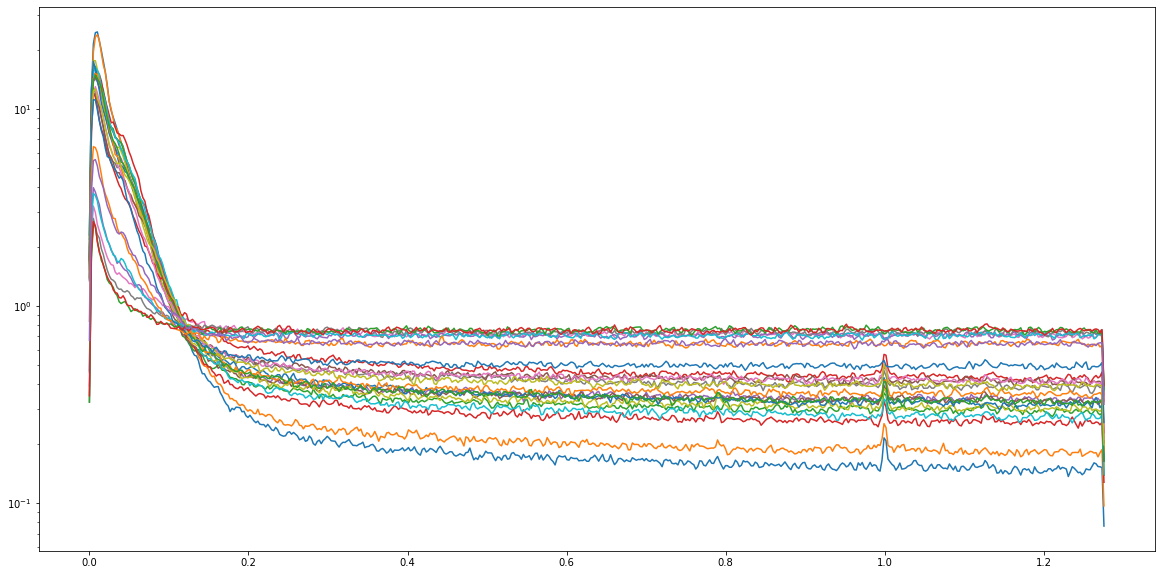

In [19]:
fig = plt.figure(figsize=(20,10))
plt.plot(f, spec_mean)
plt.yscale('log')

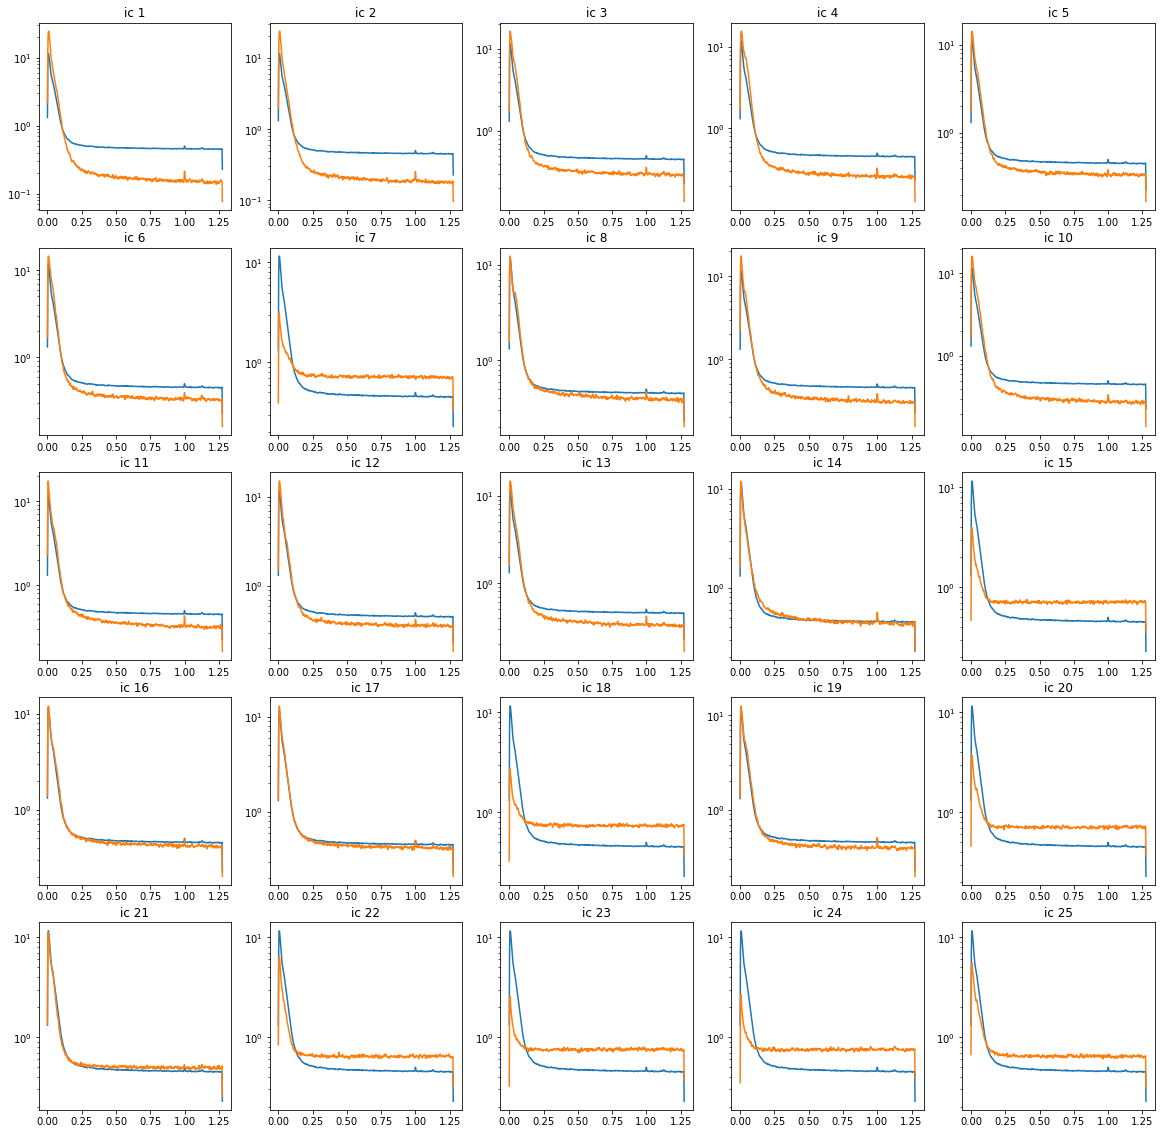

In [20]:
spec_mean_mean = np.mean(spec_mean, axis=1)

fig, ax = plt.subplots(5, 5, figsize=(20,20))

ax = ax.ravel()

for i in np.arange(25):
    ax[i].plot(f, spec_mean_mean)
    ax[i].plot(f, spec_mean[:, i])
    ax[i].set_title(f'ic {i+1}')
    ax[i].set_yscale('log')